# Data Scientist - Case Study
**Situation:** <br>

Bank XYZ is one of the leading banks in the Philippines that offers fixed term car loans. In order to improve the accuracy of the decision process whether to accept/reject the applicants, the Bank aims to rank the applications based on available information during the origination. To meet this objective, the client commissioned you to act as their analytics consultant to do the following:
1.	Provide insights on their existing portfolio.
2.	**Develop a model that will predict the borrower’s likelihood default using their internal historical data**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (precision_score, recall_score, 
    f1_score, log_loss, ConfusionMatrixDisplay)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
import catboost as CB
import xgboost as XGB

import utils

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
sns.set_palette('muted')
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# Load Data

In [2]:
with open('feature_groups.pkl', 'rb') as f:
    feature_groups = pickle.load(f)

with open('car_data.pkl', 'rb') as f:
    df = pickle.load(f)

locals().update(feature_groups)

print(df.shape)
df.head(3)

(20000, 78)


,ApplicationDate,Channel,ExistingClient,NoOfExistingLoans,Age,Sex,CivilStatus,NumberofDependents,Education,ZipCode,HousingType,YrsinResidence,DepositorTag,MonthlyIncome,EmploymentType,WorkStatus,YrsinEmploymentBusiness,WorkPosition,ForeignWorker,MonthlyExpenses,NetIncome,CarAppraisalValue,CarBrandNew,CarType,CarMake,CarMileage,CarAge,CarFuelType,WithCoMaker,RequestedLoanAmount,RequestedLoanTenor,DownPaymentPct,RepaymentAmount,InterestRatePct,DTIRatio,NoOfOpenTradelinesInLast3Mos,NoOfOpenTradelinesInLast6Mos,NoOfOpenTradelinesInLast9Mos,NoOfOpenTradelinesInLast12Mos,NoOfOpenTradelinesInLast24Mos,NoOfTradelinesWithMoreThan90DPDInLast3Mos,NoOfTradelinesWithMoreThan90DPDInLast6Mos,NoOfTradelinesWithMoreThan90DPDInLast9Mos,NoOfTradelinesWithMoreThan90DPDInLast12Mos,NoOfTradelinesWithMoreThan90DPDInLast24Mos,BankruptcyFlag,RepossessionFlag,AverageAgeofTrades,AgeofOldestTrades,Tagging,NoOfExistingLoans_grp,Age_grp,NumberofDependents_grp,MonthlyIncome_grp,CarMileage_grp,CarAge_grp,NoOfOpenTradelinesInLast3Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast3Mos_grp,YrsinResidence_grp,YrsinEmploymentBusiness_grp,MonthlyExpenses_grp,NetIncome_grp,CarAppraisalValue_grp,RequestedLoanAmount_grp,RepaymentAmount_grp,InterestRatePct_grp,DTIRatio_grp,NoOfOpenTradelinesInLast6Mos_grp,NoOfOpenTradelinesInLast9Mos_grp,NoOfOpenTradelinesInLast12Mos_grp,NoOfOpenTradelinesInLast24Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast6Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast9Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast12Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast24Mos_grp,AverageAgeofTrades_grp,AgeofOldestTrades_grp,Booked
AccountNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16995,2014-01-08,Branch,Yes,14,47,Male,DeFacto Partnership,4,College,Bad,Mortgaged,30,Yes,243566,Employed,Consultant,3,Officer,No,84934.8,158631.2,134134,No,SUV/Crossover,BMW/Jeep/Audi/Mercedes/Aston Martin/Corvette,29890,1,Hybrid,No,26826.8,12,80,2296.574792,0.05,0.009429,2,2,8,9,10,3,5,5,11,11,Yes,No,8,10,0,>5,46-60,4-6,20000-500000,25000-55000,1-2,1-2,3-4,"[23, 35)","[2, 6)","[16967.52, 585757.2]","[10491.44, 490535.2]","[123884, 211601.2)","[12965.44, 27898.44)","[1781.95985508521, 3540.50707019792)","[0.05, 0.08)","(0,0.03]","[0, 3)","[7, 8]","[9, 10]","[10, 11)","[5, 6)","[0, 6)","[10, 11]","[11, 12]","[8, 9)","[9, 12)",Yes
5495,2014-01-08,Branch,Yes,1,21,Female,DeFacto Partnership,20,College,Fair,Owned,9,Yes,12975,Employed,Contractual,2,Others,No,3048.0,9927.0,276425,Yes,Van/Truck,BMW/Jeep/Audi/Mercedes/Aston Martin/Corvette,0,0,Diesel,Yes,55285.0,24,80,2500.390808,0.08,0.192708,6,6,7,10,11,2,7,7,10,10,No,Yes,7,18,0,1-2,18-25,>6,10000-20000,0,0,>4,1-2,"[7, 15)","[2, 6)","[1488.96, 3380.4)","[4121.92, 10491.44)","[211601.2, 299996]","[49950.96, 99882.96)","[1781.95985508521, 3540.50707019792)","[0.08, 0.1)","(0.1,0.2]","[5, 6]","[7, 8]","[9, 10]","[11, 12]","[6, 7]","[7, 8)","[10, 11]","[10, 11)","[7, 8)","[18, 21)",Yes
2176,2014-01-08,Branch,Yes,3,45,Male,Single,4,College,Good,Owned,45,No,4726,Self-Employed,Owner/CEO,15,Owner/President/CEO,No,4736.4,-10.4,29063,No,SUV/Crossover,Toyota/Honda/Ford/Nissan/Chevrolet/Mazda//Peug...,21431,6,Diesel,Yes,23250.4,72,20,530.290266,0.18,0.112207,1,3,8,9,10,3,6,8,10,10,No,No,9,21,0,3-5,36-45,4-6,4000-7000,1-25000,5-7,1-2,3-4,"[35, 90]","[12, 22)","[3380.4, 6518.88)","[-94525, 240.52)","[10004, 29486)","[12965.44, 27898.44)","[423.663459076604, 933.623276954817)","[0.15, 0.18]","(0.1,0.2]","[3, 4)","[7, 8]","[9, 10]","[10, 11)","[6, 7]","[8, 9]","[10, 11]","[10, 11)","[9, 10)","[21, 24]",Yes


# Preprocess Data

### Encode/Transform Data and Drop Highly Correlated Features

In [3]:
dff = df.copy()

# Encode Yes/No categorical variables into binary
yes_no_cols = ['ExistingClient', 'DepositorTag', 'ForeignWorker', 'CarBrandNew', 
    'WithCoMaker', 'BankruptcyFlag', 'RepossessionFlag']
dff[yes_no_cols] = dff[yes_no_cols].replace({'Yes':1, 'No':0})
dff.Channel.replace({'Branch':1, 'Dealer':0}, inplace=True)
dff.Sex.replace({'Male':0, 'Female':1}, inplace=True)


# Encode some categorical variables into "ordinal"
dff.ZipCode.replace({'Bad':0, 'Fair':1, 'Good':2, 'Very Good':3}, inplace=True) 
dff.Booked.replace({'R':0, 'No':1, 'Yes':2}, inplace=True) # ?? -- will be dropped

for c in GRP_CAT_COLS:
    cc = c.split('_')[0]
    keys = df[[c, cc]].sort_values(cc)[c].drop_duplicates().values.tolist()
    vals = range(len(keys))
    dff[c].replace(dict(zip(keys, vals)), inplace=True)


# Normalize numerical variables
# Chosen models do not need this (?)


# Drop highly correlated features
dff.drop(DROP_COLS_CANDIDATES, axis=1, inplace=True)


# Dummify the rest of categorical variables
to_dummy_cols = ['CivilStatus', 'Education', 'HousingType', 
    'WorkStatus', 'CarType', 'CarMake', 'CarFuelType']


dff = dff.join(pd.get_dummies(dff[to_dummy_cols]))
dff.drop(to_dummy_cols+['ApplicationDate'], axis=1, inplace=True)

car_data_df = dff.copy()
del dff

print(car_data_df.shape)
display(car_data_df.sample(3))

(20000, 88)


,Channel,ExistingClient,NoOfExistingLoans,Age,Sex,NumberofDependents,ZipCode,YrsinResidence,DepositorTag,MonthlyIncome,ForeignWorker,NetIncome,CarBrandNew,CarMileage,WithCoMaker,RequestedLoanTenor,DownPaymentPct,RepaymentAmount,DTIRatio,NoOfOpenTradelinesInLast6Mos,NoOfOpenTradelinesInLast9Mos,NoOfOpenTradelinesInLast12Mos,NoOfOpenTradelinesInLast24Mos,NoOfTradelinesWithMoreThan90DPDInLast3Mos,NoOfTradelinesWithMoreThan90DPDInLast6Mos,NoOfTradelinesWithMoreThan90DPDInLast9Mos,NoOfTradelinesWithMoreThan90DPDInLast12Mos,NoOfTradelinesWithMoreThan90DPDInLast24Mos,BankruptcyFlag,RepossessionFlag,AverageAgeofTrades,AgeofOldestTrades,Tagging,NoOfExistingLoans_grp,Age_grp,NumberofDependents_grp,MonthlyIncome_grp,CarMileage_grp,NoOfOpenTradelinesInLast3Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast3Mos_grp,YrsinResidence_grp,YrsinEmploymentBusiness_grp,NetIncome_grp,CarAppraisalValue_grp,RepaymentAmount_grp,InterestRatePct_grp,DTIRatio_grp,NoOfOpenTradelinesInLast6Mos_grp,NoOfOpenTradelinesInLast9Mos_grp,NoOfOpenTradelinesInLast12Mos_grp,NoOfOpenTradelinesInLast24Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast6Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast9Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast12Mos_grp,NoOfTradelinesWithMoreThan90DPDInLast24Mos_grp,AverageAgeofTrades_grp,AgeofOldestTrades_grp,CivilStatus_DeFacto Partnership,CivilStatus_Married,CivilStatus_Separated/Divorced,CivilStatus_Single,Education_College,Education_PhD/Masters,Education_Primary,Education_Secondary,Education_Some College/Vocational,HousingType_Living with Parents/Relatives,HousingType_Mortgaged,HousingType_Owned,HousingType_Rented,WorkStatus_Consultant,WorkStatus_Contractual,WorkStatus_Others,WorkStatus_Owner/CEO,WorkStatus_Permanent/Regular,WorkStatus_Probationary,CarType_LuxuryCar/SportsCar/Hybrid/Electric,CarType_SUV/Crossover,CarType_Sedan/Coupe/Hatchback,CarType_Van/Truck,CarMake_BMW/Jeep/Audi/Mercedes/Aston Martin/Corvette,CarMake_Toyota/Honda/Ford/Nissan/Chevrolet/Mazda//Peugeot/Renault,CarMake_Volkswagen/Subaru/,CarFuelType_Diesel,CarFuelType_Electric,CarFuelType_Flex-Fuel,CarFuelType_Gasoline,CarFuelType_Hybrid
AccountNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19870,0,1,2,74,0,12,2,43,0,12770,1,2018.0,0,563,1,12,80,2202.543534,0.172478,1,1,1,8,5,5,5,9,11,0,1,13,22,0,1,4,3,3,1,0,3,4,3,2,3,3,0,2,0,0,0,0,2,0,2,2,4,5,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0
12953,0,0,0,27,1,6,1,4,0,3001,1,286.6,0,35393,0,60,20,1171.511317,0.390374,5,6,8,9,3,6,8,11,12,0,1,7,7,1,0,1,2,0,2,3,2,0,0,1,1,2,3,3,3,2,2,1,3,3,3,2,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0
10326,0,0,0,30,0,2,2,27,1,19439,0,10955.0,0,222485,1,12,80,4180.298943,0.215047,4,6,10,10,2,3,6,6,7,0,1,7,12,0,0,1,1,3,4,2,1,3,1,4,4,4,0,3,2,2,3,2,0,1,0,0,1,2,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1


# Choose Baseline Model


1. Feature combinations to try: [`NON_GRP_CAT_COLS + NUMERIC_COLS`],  [`NON_GRP_CAT_COLS + GRP_CAT_COLS`]
2. ML Classifiers to try: `LogisticRegression`, `CATBoost`, `XGBoost`, `RandomForest`
3. Evalutaion metrics to try: `Precision`, `Recall`, `F1`, `Log Loss`, `PR-AUC`

### Split Data into Train Set and Test Set

- 80-20 split

In [4]:
x_train, x_test, y_train, y_test = \
        train_test_split(car_data_df.drop(['Tagging'], axis=1), 
        car_data_df.Tagging, test_size = 0.2, random_state = 100)

sum(y_test)/len(y_test)

0.09625

### Train Models

In [5]:
LR_clf  = LogisticRegression(random_state = 100)
CB_clf  = CB.CatBoostClassifier(random_state = 100, verbose=False)
XGB_clf = XGB.XGBRFClassifier(random_state = 100)
RF_clf  = RandomForestClassifier(random_state = 100)

classifiers  = {'LR_clf': LR_clf, 'CB_clf': CB_clf, 'XGB_clf': XGB_clf, 'RF_clf': RF_clf}
eval_metrics = {'precision': precision_score, 'recall': recall_score, 'f1': f1_score, 
                'neg_log_loss': log_loss, 'pr_auc': utils.pr_auc_score}
feature_sets = {'feat_set1': list(set(car_data_df.columns) - set(GRP_CAT_COLS + ['Tagging'])), 
                'feat_set2': list(set(car_data_df.columns) - set(NUMERIC_COLS + ['Tagging']))}

print(len(feature_sets['feat_set1']), len(feature_sets['feat_set2']), sep=' | ')

63 | 65


In [6]:
clf_performance = {}

for featr_k, featr_v in feature_sets.items():
    x_train_ = x_train[featr_v]
    x_test_ = x_test[featr_v]

    clfs = {}
    for clf_k, clf_v in classifiers.items():
        clf_v = clf_v.fit(x_train_, y_train)
        y_pred = clf_v.predict(x_test_)

        eval_scores = {}
        for metric_k, metric_v in eval_metrics.items():
            eval_scores.update({metric_k:metric_v(y_test, y_pred)})
        
        clfs.update({clf_k:eval_scores})

    clf_performance.update({featr_k:clfs})

del x_train_, x_test_, clfs, eval_scores    

### Evaluate Models and Choose Baseline Model

In [7]:
perf_df = pd.DataFrame.from_dict(
    {(i,j): clf_performance[i][j] 
        for i in clf_performance.keys() 
        for j in clf_performance[i].keys()},
    orient='columns').round(3)
perf_df

feat_set1                       feat_set2                      
                LR_clf CB_clf XGB_clf RF_clf    LR_clf CB_clf XGB_clf RF_clf
precision        0.507  0.930   0.842  0.983     0.919  0.928   0.858  0.973
recall           0.182  0.823   0.608  0.603     0.855  0.839   0.629  0.657
f1               0.268  0.873   0.706  0.747     0.886  0.881   0.726  0.784
neg_log_loss     3.307  0.794   1.684  1.356     0.734  0.751   1.580  1.200
pr_auc           0.384  0.885   0.744  0.812     0.894  0.891   0.761  0.832

- Choosing LogisticRegression; the highest F1 score,  lowest log loss, and highest pr auc
- LogisticRegression generally performed better on `feat_set2` <br> which is a combination of `NON_GRP_CAT_COLS` and `GRP_CAT_COLS`

In [8]:
# perf_df['feat_set2'] - perf_df['feat_set1'] > 0

# Final Model (Improve Baseline Model)

- Feature selection (recursive feature elimination)
- GridSeachCV (hyperparameter tuning + cross validation)

In [9]:
x_train_ = x_train[feature_sets['feat_set2']]
x_test_ = x_test[feature_sets['feat_set2']]

## Feature Selection

In [10]:
LR_clf_rfe = LogisticRegression(random_state=100)

rfecv = RFECV(
    estimator=LR_clf_rfe,
    step=1,
    cv=5,
    scoring='f1',
    min_features_to_select=1,
)
rfecv.fit(x_train_, y_train)

RFECV(cv=5, estimator=LogisticRegression(random_state=100), scoring='f1')

#### Optimal number of features is 55, down from 65

- This is less than 79 which is the total no. of potential features from the original data

In [11]:

print(rfecv.n_features_)

# Columns to drop
drop_cols = np.array(feature_sets['feat_set2'])[rfecv.ranking_ != 1]

x_train_.drop(drop_cols, axis=1, inplace=True)
x_test_.drop(drop_cols, axis=1, inplace=True)

drop_cols

55


array(['NoOfTradelinesWithMoreThan90DPDInLast6Mos_grp',
       'CivilStatus_DeFacto Partnership',
       'CarMake_Toyota/Honda/Ford/Nissan/Chevrolet/Mazda//Peugeot/Renault',
       'NoOfTradelinesWithMoreThan90DPDInLast24Mos_grp',
       'WorkStatus_Probationary', 'Education_Some College/Vocational',
       'AverageAgeofTrades_grp', 'NetIncome_grp',
       'YrsinEmploymentBusiness_grp', 'NoOfOpenTradelinesInLast6Mos_grp'],
      dtype='<U65')

## GridSearchCV

In [12]:
LR_params = {
    'solver': ['newton-cg', 'lbfgs', 'sag'], 
    'C': [0.1, 1, 10, 20, 50],
    'fit_intercept': [True, False],
    'class_weight': ['auto', 'none'],
    'max_iter': [100, 200]}

LR_clf_ = LogisticRegression(random_state=19)
LR_clf_ = GridSearchCV(
    estimator=LR_clf_, 
    param_grid=LR_params,
    scoring=list(eval_metrics.keys())[:-1],
    refit='f1',
    return_train_score=True)

LR_clf_.fit(x_train_, y_train)

GridSearchCV(estimator=LogisticRegression(random_state=19),
             param_grid={'C': [0.1, 1, 10, 20, 50],
                         'class_weight': ['auto', 'none'],
                         'fit_intercept': [True, False], 'max_iter': [100, 200],
                         'solver': ['newton-cg', 'lbfgs', 'sag']},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'neg_log_loss'])

#### The model did not improved and have about the same scores on all metrics as the baseline model

In [13]:
print(f'Best params: {LR_clf_.best_params_} \n')

y_pred_ = LR_clf_.predict(x_test_)

eval_scores = {}
for metric_k, metric_v in eval_metrics.items():
    eval_scores.update({metric_k:round(metric_v(y_test, y_pred_),3)})

print(f'Performance of Baseline Model: {perf_df.feat_set2.LR_clf.to_dict()}')
print(f'Performance  after GridSearch: {eval_scores}')


Best params: {'C': 10, 'class_weight': 'auto', 'fit_intercept': False, 'max_iter': 100, 'solver': 'newton-cg'} 

Performance of Baseline Model: {'precision': 0.919, 'recall': 0.855, 'f1': 0.886, 'neg_log_loss': 0.734, 'pr_auc': 0.894}
Performance  after GridSearch: {'precision': 0.919, 'recall': 0.855, 'f1': 0.886, 'neg_log_loss': 0.734, 'pr_auc': 0.894}


## Misc.

NOTE: As per case study file, we can rank the applicants by predicting the probabilities i.e. `predict_poba(X`) method of the model (`LR_clf_.best_estimator_.predict_proba(x_test_)`)

In [14]:
res = LR_clf_.cv_results_

### Plot train vs test performance
- no overfitting, note LR uses L2 penalty by default

,id,data,precision,recall,f1,neg_log_loss
198,78,test,89.223248,86.387295,87.755236,-6.327030
48,48,train,89.902040,86.417911,88.124766,-5.886871


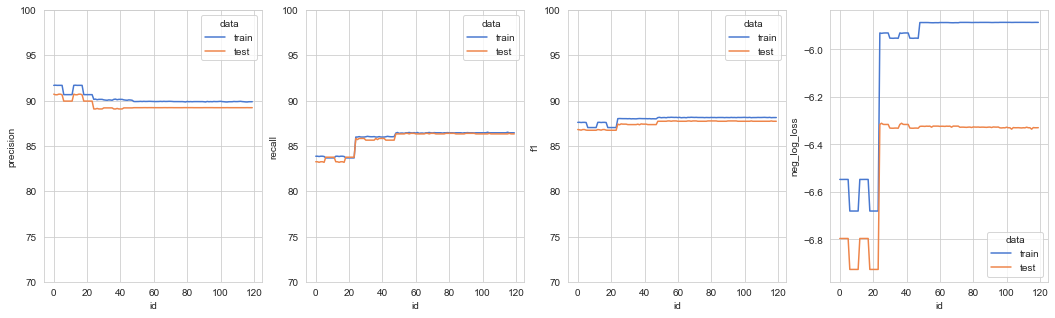

In [15]:
dfs = []
scoring = list(eval_metrics.keys())[:-1]
for s in scoring:
    t1 = f'mean_train_{s}'
    t2 = f'mean_test_{s}'
    t3 = ['train','test']
    df_ = pd.DataFrame([res[t1], res[t2]], index=t3).T * 100
    df_ = pd.melt(df_, var_name='data', value_name=s, value_vars=t3, ignore_index=False)
    dfs.append(df_.set_index('data', append=True))

df_ = pd.concat(dfs, axis=1).reset_index().rename(columns={'level_0':'id'}) 
display(df_.sample(2))

fig, axs = plt.subplots(1, len(scoring), figsize=(18,5))
for i,s in enumerate(scoring):
    sns.lineplot(x='id', y=s, hue='data', data=df_, ax=axs[i])
    if i != len(scoring)-1:
        axs[i].set_ylim(70,100)

### Plot confusion matrix

- 8% false positive, 15% false negative

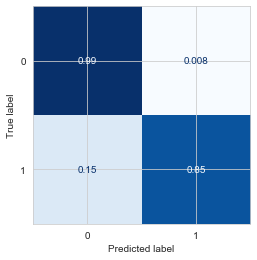

In [16]:
ax = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_, normalize='true', colorbar=False, cmap=PLT)

### Plot coefficients of the model

- consistent with EDA
- except: CarBrandNew, BankruptcyFlag, ReposessionFlag

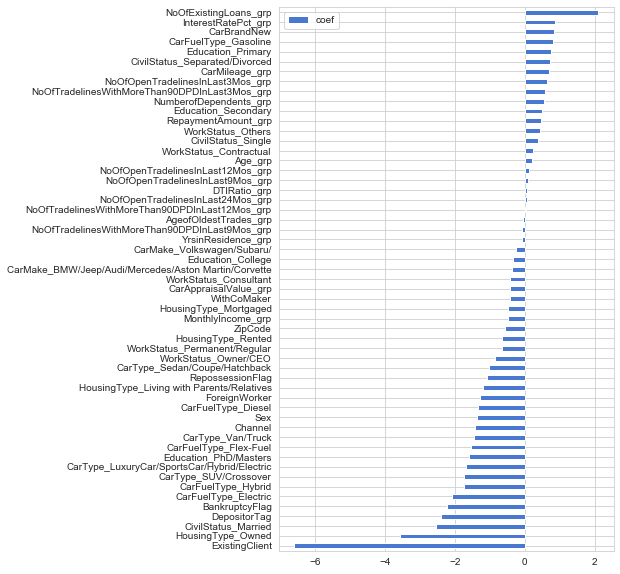

In [17]:
pd.DataFrame(LR_clf_.best_estimator_.coef_, columns=x_train_.columns, index=['coef']).T.sort_values('coef').plot.barh(figsize=(6,10))

In [18]:
#  pvals = utils.logit_pvalue(LR_clf_.best_estimator_, x_train_)

### Save model

In [19]:
with open('LR_final_model.pkl', 'wb') as f:
    pickle.dump(LR_clf_, f)

# Key Takeaways, Recommendations and Next Steps

- Trying different models, we found out that Logistic Regression performed best <br> with the following metric scores during final modelling: `{'precision': 0.919, 'recall': 0.855, 'f1': 0.886, 'neg_log_loss': 0.734, 'pr_auc': 0.894}`
- Perhaps the performance of the model can be improved by oversampling the minority class e.g. using SMOTE. The model could probably be retrained and improved as Bank XYZ receives more loan applications; the model might not generalize well since the +labels only came from 2017 (?). Including other features that are indicative of a person's financial capacity should probably help e.g. assets other than house and their value and perhaps some 'alternative' data

Next Steps:

1. Try oversampling minority class using SMOTE
    - TODO: upgrade to Python (>= 3.8), imbalanced-learn requires Scikit-learn (>= 1.1.0)
2. Feature selection, check the significance of the model coefficients, drop features with p > 0.5 (?)
3. Benchmark model
4. Check decision boundary
5. Try modelling 2017 data only? [instead of random undersampling]
6. **Adjust probability threshold to let the business decide what works best for the bank**